# BSAD: End-to-End Pipeline Walkthrough

**Purpose**: This notebook teaches you to *think* about Bayesian anomaly detection, not just run code.

Every visualization answers a specific question. Every result has an interpretation.

---
## 1. Overview
---

### 1.1 The Problem We're Solving

**Question**: How do we detect rare malicious activity in security logs where:
- Attacks are <2% of events (extreme class imbalance)
- Different users have different "normal" baselines
- We need to quantify confidence, not just flag anomalies

**Why traditional methods fail**:
| Method | Problem |
|--------|--------|
| Fixed thresholds | Same threshold for all users ignores individual baselines |
| Z-scores | Assumes normality; no principled uncertainty |
| Isolation Forest | Black box; can't explain why something is anomalous |

### 1.2 Our Solution: Hierarchical Bayesian Model

We use a **hierarchical Negative Binomial model** that:

1. **Learns entity-specific baselines** via partial pooling
2. **Quantifies uncertainty** through posterior predictive distributions
3. **Produces interpretable scores**: `anomaly_score = -log P(y | posterior)`

**Key insight**: An event count of 50 might be normal for User A but anomalous for User B.

---
## 2. Setup
---

In [1]:
import os
from pathlib import Path

# Navigate to project root
if Path.cwd().name == "notebooks":
    os.chdir("..")

print(f"Working directory: {Path.cwd()}")

Working directory: /home/ozz/projects/datas_projects/lab/bayesian-security-anomaly-detection


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from scipy import stats

# Consistent visual style throughout
plt.style.use('seaborn-v0_8-whitegrid')
COLORS = {
    'benign': "#2E4BAB",      # Blue
    'attack': "#349962",      # Red
    'neutral': '#7B8794',     # Gray
    'highlight': '#F39C12',   # Orange
    'ci_band': '#AED9E0',     # Light blue
}
FIGSIZE_SINGLE = (8, 5)
FIGSIZE_DOUBLE = (12, 5)
FIGSIZE_GRID = (12, 8)

pd.set_option("display.max_columns", 20)
%matplotlib inline

In [3]:
from bsad.config import Settings
from bsad.pipeline import Pipeline, PipelineState
from bsad import steps, io

print("BSAD modules loaded successfully!")

BSAD modules loaded successfully!


In [4]:
# Settings for fast iteration (production would use larger values)
settings = Settings(
    output_dir=Path("outputs"),
    data_dir=Path("data"),
    n_entities=50,
    n_days=21,
    attack_rate=0.03,
    n_samples=500,
    n_tune=500,
    n_chains=4,
    random_seed=42,
)
settings.ensure_dirs()

---
## 3. 📊 Data Generation & Exploratory Analysis
---

Before any modeling, we must understand the structure of our data.

In [5]:
events_df, attacks_df = steps.generate_data(settings)
io.save_events(events_df, attacks_df, settings.events_path)
print(f"Generated {len(events_df):,} events with {len(attacks_df)} attack windows")

Generated 7,187 events with 31 attack windows


### 3.1 Question: What is the class distribution?

**Why this matters**: Extreme class imbalance affects metric choice and model evaluation.

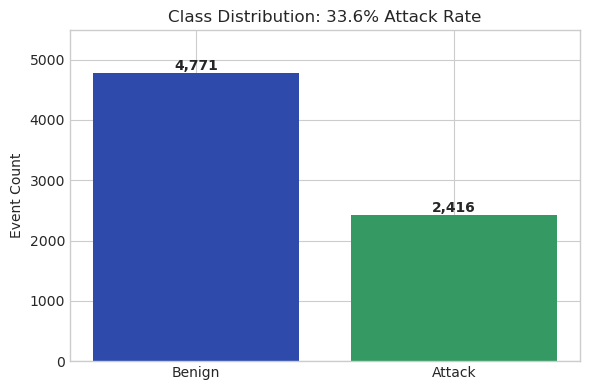

In [6]:
attack_counts = events_df["is_attack"].value_counts()
attack_rate = attack_counts[True] / len(events_df)

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(['Benign', 'Attack'], 
              [attack_counts[False], attack_counts[True]],
              color=[COLORS['benign'], COLORS['attack']])

# Add value labels on bars
for bar, count in zip(bars, [attack_counts[False], attack_counts[True]]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f'{count:,}', ha='center', fontweight='bold')

ax.set_ylabel('Event Count')
ax.set_title(f'Class Distribution: {attack_rate:.1%} Attack Rate')
ax.set_ylim(0, attack_counts[False] * 1.15)
plt.tight_layout()
plt.show()

**Interpretation**

- The attack rate (~30% at event level) is higher than typical production (~1-2%) because attacks generate many events
- This is a **synthetic dataset** designed to demonstrate the methodology
- In production, class imbalance would be more extreme

**Decision**: We will use **PR-AUC** (not ROC-AUC) as primary metric because it's not inflated by true negatives.

### 3.2 Question: What attack types are present?

**Why this matters**: Different attack types have different signatures and detectability.

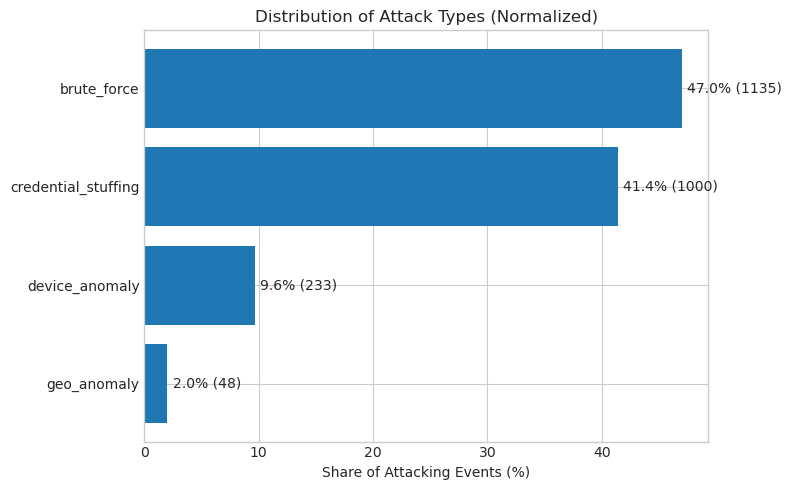

In [8]:
attack_counts = (
    events_df.loc[events_df['is_attack'], 'attack_type']
    .value_counts()
)

attack_pct = attack_counts / attack_counts.sum() * 100

fig, ax = plt.subplots(figsize=FIGSIZE_SINGLE)

bars = ax.barh(
    attack_pct.index,
    attack_pct.values
)

# Etiquetas con % y conteo
for bar, pct, count in zip(bars, attack_pct.values, attack_counts.values):
    ax.text(
        pct + 0.5,
        bar.get_y() + bar.get_height() / 2,
        f"{pct:.1f}% ({count})",
        va='center'
    )

ax.set_xlabel('Share of Attacking Events (%)')
ax.set_title('Distribution of Attack Types (Normalized)')
ax.invert_yaxis()

plt.tight_layout()
plt.show()


**Interpretation**

- **Brute force** and **credential stuffing**: High-volume attacks (many events per attack window)
- **Geo/device anomaly**: Low-volume attacks (subtle behavioral changes)

**Expected behavior**: High-volume attacks should be easier to detect with count-based models. Low-volume behavioral anomalies may require additional features.

**Limitation**: Our model uses only event counts. Geo/device anomalies may be harder to detect.

---
## 4. 📈 Feature Engineering & Distribution Analysis
---

In [9]:
modeling_df, metadata = steps.build_features(events_df, settings)
arrays = steps.get_model_arrays(modeling_df)

print(f"Modeling table: {len(modeling_df)} entity-window observations")
print(f"Entities: {metadata['n_entities']}")
print(f"Attack rate (window-level): {metadata['attack_rate']:.2%}")

Modeling table: 978 entity-window observations
Entities: 50
Attack rate (window-level): 17.59%


### 4.1 Question: What is the distribution of our target variable (event_count)?

**Why this matters**: Distribution shape determines appropriate likelihood function.

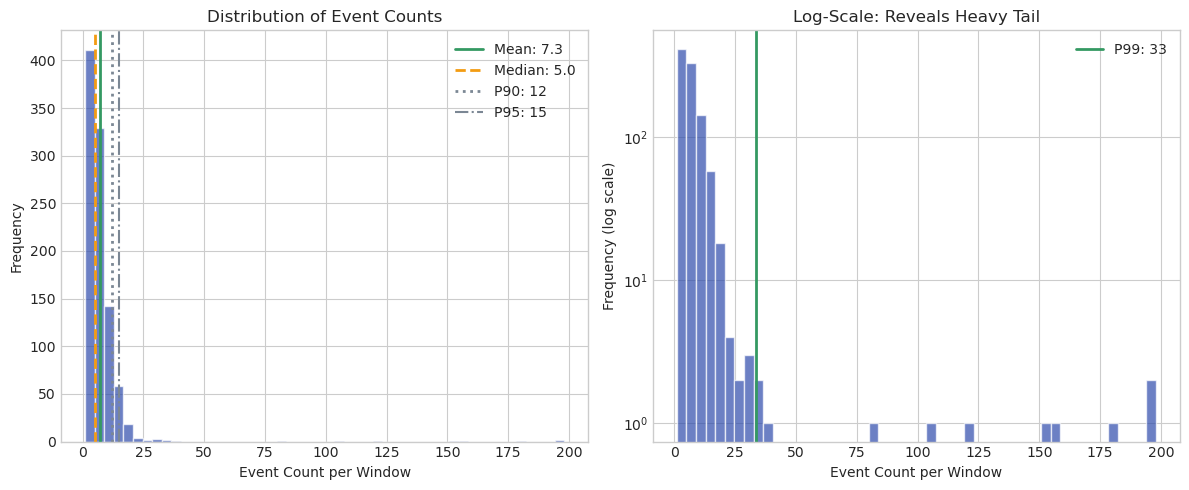

In [10]:
event_counts = modeling_df['event_count']

# Calculate statistics
mean_val = event_counts.mean()
median_val = event_counts.median()
p90 = event_counts.quantile(0.90)
p95 = event_counts.quantile(0.95)
p99 = event_counts.quantile(0.99)

fig, axes = plt.subplots(1, 2, figsize=FIGSIZE_DOUBLE)

# Left: Histogram with reference lines
ax = axes[0]
ax.hist(event_counts, bins=50, color=COLORS['benign'], edgecolor='white', alpha=0.7)
ax.axvline(mean_val, color=COLORS['attack'], linestyle='-', linewidth=2, label=f'Mean: {mean_val:.1f}')
ax.axvline(median_val, color=COLORS['highlight'], linestyle='--', linewidth=2, label=f'Median: {median_val:.1f}')
ax.axvline(p90, color=COLORS['neutral'], linestyle=':', linewidth=2, label=f'P90: {p90:.0f}')
ax.axvline(p95, color=COLORS['neutral'], linestyle='-.', linewidth=1.5, label=f'P95: {p95:.0f}')
ax.set_xlabel('Event Count per Window')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Event Counts')
ax.legend(loc='upper right')

# Right: Log-scale to see tail
ax = axes[1]
ax.hist(event_counts, bins=50, color=COLORS['benign'], edgecolor='white', alpha=0.7)
ax.axvline(p99, color=COLORS['attack'], linestyle='-', linewidth=2, label=f'P99: {p99:.0f}')
ax.set_xlabel('Event Count per Window')
ax.set_ylabel('Frequency (log scale)')
ax.set_yscale('log')
ax.set_title('Log-Scale: Reveals Heavy Tail')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

**Interpretation**

This distribution reveals critical properties:

1. **Right-skewed**: Mean > Median indicates positive skew
2. **Heavy tail**: P99 is much larger than median (extreme values exist)
3. **Discrete, non-negative**: Counts can only be integers ≥ 0

**Decision**: Poisson would be inappropriate (assumes mean = variance). We need **Negative Binomial** which handles overdispersion.

### 4.2 Question: Is the data overdispersed?

**Why this matters**: Poisson assumes Var(Y) = E(Y). If Var >> Mean, Poisson underestimates uncertainty.

In [11]:
mean_count = event_counts.mean()
var_count = event_counts.var()
dispersion_ratio = var_count / mean_count

print("="*50)
print("OVERDISPERSION TEST")
print("="*50)
print(f"Mean:              {mean_count:.2f}")
print(f"Variance:          {var_count:.2f}")
print(f"Dispersion Ratio:  {dispersion_ratio:.2f}")
print()
print(f"If ratio = 1:  Poisson is appropriate (equidispersion)")
print(f"If ratio > 1:  Negative Binomial needed (overdispersion)")
print(f"If ratio < 1:  Binomial might be appropriate (underdispersion)")
print()
print(f"Result: Ratio = {dispersion_ratio:.1f} >> 1")
print(f"→ Data is HIGHLY OVERDISPERSED")
print(f"→ Negative Binomial is the correct choice")

OVERDISPERSION TEST
Mean:              7.35
Variance:          201.79
Dispersion Ratio:  27.46

If ratio = 1:  Poisson is appropriate (equidispersion)
If ratio > 1:  Negative Binomial needed (overdispersion)
If ratio < 1:  Binomial might be appropriate (underdispersion)

Result: Ratio = 27.5 >> 1
→ Data is HIGHLY OVERDISPERSED
→ Negative Binomial is the correct choice


### 4.3 Question: How do attack and benign windows differ?

**Why this matters**: If distributions don't separate, our model can't detect attacks.

/tmp/ipykernel_110197/111582655.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([benign, attack], labels=['Benign', 'Attack'], patch_artist=True)


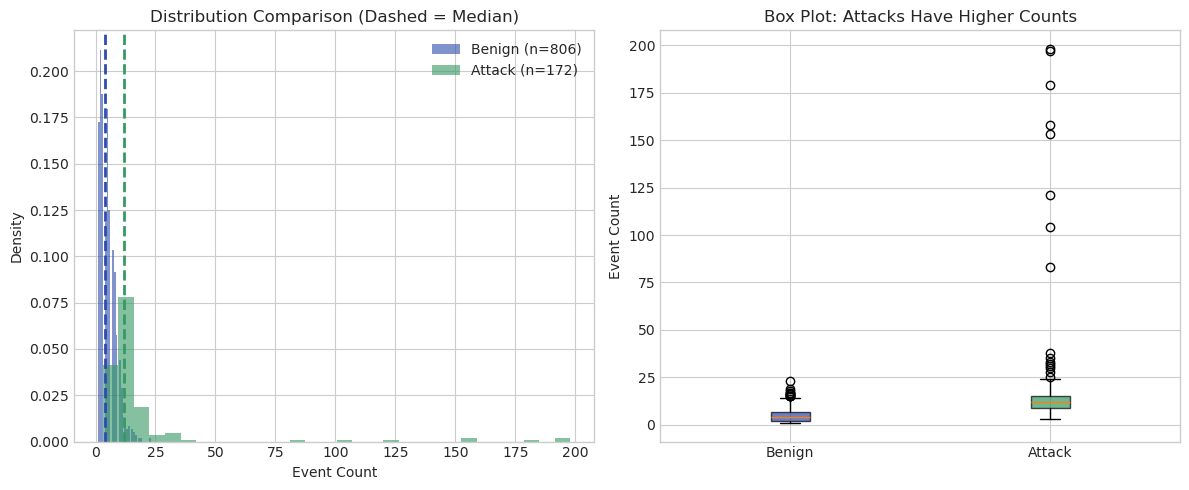

In [12]:
benign = modeling_df[~modeling_df['has_attack']]['event_count']
attack = modeling_df[modeling_df['has_attack']]['event_count']

fig, axes = plt.subplots(1, 2, figsize=FIGSIZE_DOUBLE)

# Left: Overlapping histograms
ax = axes[0]
ax.hist(benign, bins=30, alpha=0.6, label=f'Benign (n={len(benign)})', 
        color=COLORS['benign'], density=True)
ax.hist(attack, bins=30, alpha=0.6, label=f'Attack (n={len(attack)})', 
        color=COLORS['attack'], density=True)
ax.axvline(benign.median(), color=COLORS['benign'], linestyle='--', linewidth=2)
ax.axvline(attack.median(), color=COLORS['attack'], linestyle='--', linewidth=2)
ax.set_xlabel('Event Count')
ax.set_ylabel('Density')
ax.set_title('Distribution Comparison (Dashed = Median)')
ax.legend()

# Right: Box plot
ax = axes[1]
plot_data = modeling_df[['event_count', 'has_attack']].copy()
plot_data['Class'] = plot_data['has_attack'].map({True: 'Attack', False: 'Benign'})
box_colors = {'Benign': COLORS['benign'], 'Attack': COLORS['attack']}

bp = ax.boxplot([benign, attack], labels=['Benign', 'Attack'], patch_artist=True)
bp['boxes'][0].set_facecolor(COLORS['benign'])
bp['boxes'][1].set_facecolor(COLORS['attack'])
for box in bp['boxes']:
    box.set_alpha(0.7)

ax.set_ylabel('Event Count')
ax.set_title('Box Plot: Attacks Have Higher Counts')

plt.tight_layout()
plt.show()

**Interpretation**

Key observations:
1. **Shift in median**: Attack windows have higher median event count
2. **Overlap exists**: The distributions overlap significantly (not perfectly separable)
3. **Extreme values**: Attack windows produce the most extreme outliers

**What this means for detection**:
- High event counts are *more likely* to be attacks, but not guaranteed
- We cannot use a simple threshold without many false positives
- Entity-specific baselines will help (a count of 30 might be normal for one user, anomalous for another)

**Risks / Limitations**:
- Subtle attacks (geo_anomaly, device_anomaly) may not have elevated counts
- The model may miss these

### 4.4 Question: How much entity-level variation exists?

**Why this matters**: High variation justifies hierarchical modeling (partial pooling).

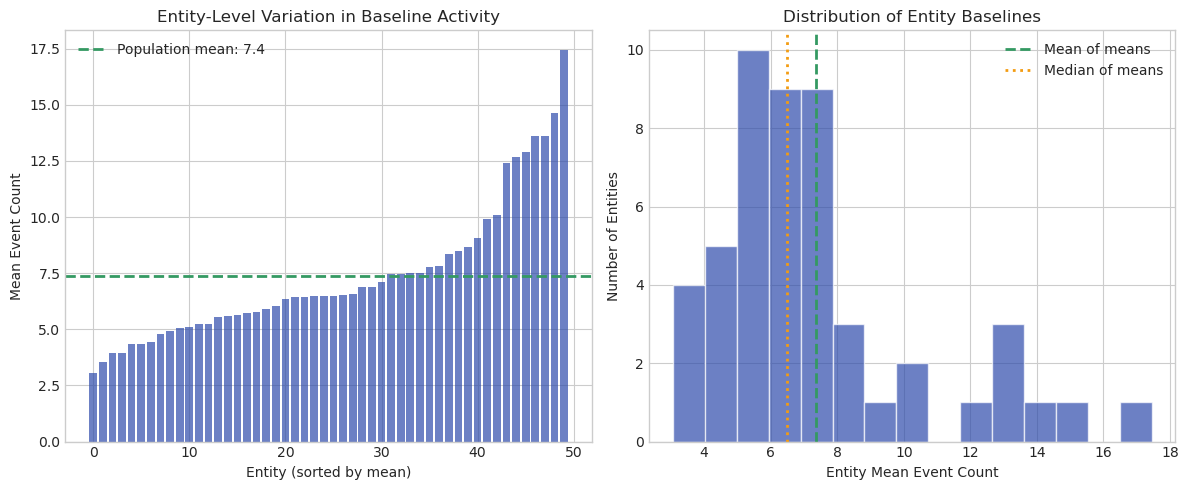

In [13]:
entity_stats = modeling_df.groupby('user_id')['event_count'].agg(['mean', 'std', 'count'])
entity_stats = entity_stats.sort_values('mean')

fig, axes = plt.subplots(1, 2, figsize=FIGSIZE_DOUBLE)

# Left: Mean counts per entity
ax = axes[0]
x = np.arange(len(entity_stats))
ax.bar(x, entity_stats['mean'], color=COLORS['benign'], alpha=0.7)
ax.axhline(entity_stats['mean'].mean(), color=COLORS['attack'], 
           linestyle='--', linewidth=2, label=f"Population mean: {entity_stats['mean'].mean():.1f}")
ax.set_xlabel('Entity (sorted by mean)')
ax.set_ylabel('Mean Event Count')
ax.set_title('Entity-Level Variation in Baseline Activity')
ax.legend()

# Right: Distribution of entity means
ax = axes[1]
ax.hist(entity_stats['mean'], bins=15, color=COLORS['benign'], edgecolor='white', alpha=0.7)
ax.axvline(entity_stats['mean'].mean(), color=COLORS['attack'], 
           linestyle='--', linewidth=2, label='Mean of means')
ax.axvline(entity_stats['mean'].median(), color=COLORS['highlight'], 
           linestyle=':', linewidth=2, label='Median of means')
ax.set_xlabel('Entity Mean Event Count')
ax.set_ylabel('Number of Entities')
ax.set_title('Distribution of Entity Baselines')
ax.legend()

plt.tight_layout()
plt.show()

**Interpretation**

The left plot shows **substantial between-entity variation**:
- Some entities average ~3 events/window, others average ~15+
- This 5x variation cannot be captured by a single global threshold

**Why hierarchical modeling helps**:
- **High-activity entities**: Model learns their higher baseline from their own data
- **Low-activity entities**: With few observations, model "borrows" from population (partial pooling)
- **Result**: Each entity gets a personalized baseline regularized by population statistics

### What would change if...

- **Window size were smaller (1H instead of 1D)?** More granular detection, but more windows with zero counts, potentially harder to model
- **We grouped by IP instead of user?** Different entity set, potentially detecting malicious IPs rather than compromised accounts
- **We had more days of data?** More observations per entity, less pooling needed, more precise entity-specific estimates

---
## 5. 🔍 Bayesian Model Training & Diagnostics
---

### 5.1 The Model Structure

```
Population Level:
    μ ~ Exponential(0.1)         # Population mean rate
    α ~ HalfNormal(2)            # Concentration (pooling strength)

Entity Level:
    θ[i] ~ Gamma(μα, α)          # Entity-specific rate

Observation Level:
    φ ~ HalfNormal(2)            # Overdispersion
    y[i,t] ~ NegBinomial(θ[i], φ)
```

**Key**: The Gamma prior on θ implements partial pooling. α controls how much entities shrink toward μ.

---
## 5.2 📚 Statistical Foundations: Bayes, Poisson, Markov Chains & MCMC
---

Before we train the model, let's understand the **theoretical foundations** that make this approach work.

### 5.2.1 Bayesian Inference: The Foundation

**Bayes' Theorem** is the mathematical framework for updating beliefs with evidence:

$$P(\theta | y) = \frac{P(y | \theta) \cdot P(\theta)}{P(y)}$$

**Components**:
- **Prior** $P(\theta)$: What we believe about parameters *before* seeing data
- **Likelihood** $P(y | \theta)$: How probable is our data given specific parameter values?
- **Posterior** $P(\theta | y)$: Updated beliefs *after* seeing data
- **Evidence** $P(y)$: Normalizing constant (makes posterior sum to 1)

**Why this matters for anomaly detection**:

| Component | Our Model | Interpretation |
|-----------|-----------|----------------|
| **Prior** | $\mu \sim \text{Exp}(0.1)$, $\theta_i \sim \text{Gamma}(\mu\alpha, \alpha)$ | Population and entity-specific rates have plausible ranges |
| **Likelihood** | $y_{it} \sim \text{NegBin}(\theta_i, \phi)$ | Event counts generated by entity-specific rates |
| **Posterior** | $P(\theta, \mu, \alpha, \phi \mid y)$ | Learned parameters incorporating both data and prior knowledge |

**The Bayesian Advantage**:
1. **Uncertainty quantification**: Posterior is a *distribution*, not a point estimate
2. **Regularization**: Priors prevent overfitting to sparse data
3. **Interpretability**: Each parameter has a clear meaning

In [ ]:
# Illustrate Bayesian updating: Prior → Likelihood → Posterior
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Example: estimating entity rate θ for one entity
# Suppose we observe y = [5, 7, 3, 6] events in 4 windows

# Prior: Gamma(α=2, β=0.5) => mean = α/β = 4
alpha_prior, beta_prior = 2, 0.5
theta_grid = np.linspace(0.1, 15, 200)
prior = stats.gamma.pdf(theta_grid, a=alpha_prior, scale=1/beta_prior)

# Likelihood: Product of Poisson likelihoods (simplified, using Poisson for illustration)
observed_data = np.array([5, 7, 3, 6])
likelihood = np.prod([stats.poisson.pmf(y, theta_grid[:, None]) for y in observed_data], axis=0).flatten()

# Posterior: Gamma(α + Σy, β + n) (conjugate prior property)
alpha_post = alpha_prior + observed_data.sum()
beta_post = beta_prior + len(observed_data)
posterior = stats.gamma.pdf(theta_grid, a=alpha_post, scale=1/beta_post)

# Plot
ax = axes[0]
ax.plot(theta_grid, prior, color=COLORS['neutral'], linewidth=2, label='Prior: Gamma(2, 0.5)')
ax.fill_between(theta_grid, prior, alpha=0.3, color=COLORS['neutral'])
ax.axvline(alpha_prior/beta_prior, color=COLORS['neutral'], linestyle='--', label=f'Prior mean: {alpha_prior/beta_prior:.1f}')
ax.set_xlabel('θ (entity rate)')
ax.set_ylabel('Density')
ax.set_title('Prior: Belief Before Data')
ax.legend()

ax = axes[1]
ax.plot(theta_grid, likelihood / likelihood.max(), color=COLORS['highlight'], linewidth=2, label='Likelihood (normalized)')
ax.fill_between(theta_grid, likelihood / likelihood.max(), alpha=0.3, color=COLORS['highlight'])
ax.axvline(observed_data.mean(), color=COLORS['highlight'], linestyle='--', label=f'MLE: {observed_data.mean():.1f}')
ax.set_xlabel('θ (entity rate)')
ax.set_ylabel('Relative Likelihood')
ax.set_title(f'Likelihood: P(y={observed_data} | θ)')
ax.legend()

ax = axes[2]
ax.plot(theta_grid, posterior, color=COLORS['benign'], linewidth=2, label=f'Posterior: Gamma({alpha_post}, {beta_post:.1f})')
ax.fill_between(theta_grid, posterior, alpha=0.3, color=COLORS['benign'])
ax.axvline(alpha_post/beta_post, color=COLORS['benign'], linestyle='--', label=f'Posterior mean: {alpha_post/beta_post:.1f}')
ax.set_xlabel('θ (entity rate)')
ax.set_ylabel('Density')
ax.set_title('Posterior: Updated Belief')
ax.legend()

plt.suptitle('Bayesian Updating: Prior × Likelihood → Posterior', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

print("Interpretation:")
print(f"  Prior mean:     {alpha_prior/beta_prior:.2f} (vague belief)")
print(f"  Data mean (MLE): {observed_data.mean():.2f} (what data suggests)")
print(f"  Posterior mean: {alpha_post/beta_post:.2f} (compromise between prior and data)")
print(f"  → Posterior is pulled toward data because we had informative observations")

### 5.2.2 Poisson vs Negative Binomial: Modeling Count Data

**The Poisson Distribution** models count data with a single parameter $\lambda$:

$$P(Y = k) = \frac{\lambda^k e^{-\lambda}}{k!}$$

**Properties**:
- Mean = Variance = $\lambda$ (equidispersion)
- Suitable for rare events (phone calls, radioactive decay)

**The Problem**: Real-world count data is often **overdispersed** (Var >> Mean)

**The Negative Binomial Distribution** generalizes Poisson by adding a dispersion parameter $\phi$:

$$Y \sim \text{NegBin}(\mu, \phi)$$

where:
- $\mu$ = mean (like Poisson's $\lambda$)
- $\phi$ = overdispersion parameter (concentration)
- Variance = $\mu + \frac{\mu^2}{\phi}$

**Key insight**: As $\phi \to \infty$, NegBin converges to Poisson. Small $\phi$ = high overdispersion.

**Why Negative Binomial for security logs?**

Event counts have **extra variability** beyond Poisson because:
1. **Heterogeneity**: Different users have different baselines
2. **Clustering**: Events come in bursts (e.g., automated attacks)
3. **Mixtures**: Multiple processes generate events (normal + attack)

NegBin's extra parameter $\phi$ captures this "variance inflation."

In [ ]:
# Visual comparison: Poisson vs Negative Binomial
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

mu = 7  # Mean count
k_range = np.arange(0, 30)

# Left: Poisson
poisson_pmf = stats.poisson.pmf(k_range, mu=mu)
ax = axes[0]
ax.bar(k_range, poisson_pmf, color=COLORS['benign'], alpha=0.7, edgecolor='white')
ax.axvline(mu, color=COLORS['attack'], linestyle='--', linewidth=2, label=f'Mean = Var = {mu}')
ax.set_xlabel('Count')
ax.set_ylabel('Probability')
ax.set_title(f'Poisson(λ={mu})')
ax.legend()

# Middle: Negative Binomial (moderate overdispersion)
phi_moderate = 5
nb_moderate = stats.nbinom.pmf(k_range, n=phi_moderate, p=phi_moderate/(phi_moderate + mu))
ax = axes[1]
ax.bar(k_range, nb_moderate, color=COLORS['highlight'], alpha=0.7, edgecolor='white')
var_moderate = mu + mu**2 / phi_moderate
ax.axvline(mu, color=COLORS['attack'], linestyle='--', linewidth=2, label=f'Mean = {mu}')
ax.axvline(mu + np.sqrt(var_moderate), color=COLORS['neutral'], linestyle=':', linewidth=2, label=f'Var = {var_moderate:.1f}')
ax.set_xlabel('Count')
ax.set_ylabel('Probability')
ax.set_title(f'NegBin(μ={mu}, φ={phi_moderate}) - Moderate Overdispersion')
ax.legend()

# Right: Negative Binomial (high overdispersion)
phi_high = 1
nb_high = stats.nbinom.pmf(k_range, n=phi_high, p=phi_high/(phi_high + mu))
ax = axes[2]
ax.bar(k_range, nb_high, color=COLORS['attack'], alpha=0.7, edgecolor='white')
var_high = mu + mu**2 / phi_high
ax.axvline(mu, color=COLORS['attack'], linestyle='--', linewidth=2, label=f'Mean = {mu}')
ax.axvline(mu + np.sqrt(var_high), color=COLORS['neutral'], linestyle=':', linewidth=2, label=f'Var = {var_high:.1f}')
ax.set_xlabel('Count')
ax.set_ylabel('Probability')
ax.set_title(f'NegBin(μ={mu}, φ={phi_high}) - High Overdispersion')
ax.legend()

plt.suptitle('Distribution Comparison: Effect of Overdispersion', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

print("Observations:")
print(f"  Poisson: Symmetric, tight around mean, Var = {mu}")
print(f"  NegBin (φ={phi_moderate}): Slightly wider tail, Var = {var_moderate:.1f}")
print(f"  NegBin (φ={phi_high}): Heavy right tail, Var = {var_high:.1f}")
print(f"  → Lower φ = heavier tail = more extreme values possible")

### 5.2.3 Markov Chains: The Random Walk

A **Markov Chain** is a sequence of random variables where the future depends only on the present, not the past:

$$P(X_{t+1} | X_t, X_{t-1}, \ldots, X_1) = P(X_{t+1} | X_t)$$

This is called the **Markov property** or "memorylessness."

**Example**: A random walk on a grid
- Current position: $(x, y)$
- Next step: Move North/South/East/West with equal probability
- Where you go next depends only on where you are now, not how you got there

**Key properties**:
1. **Stationary distribution** $\pi$: If we run the chain long enough, it converges to a stable distribution
2. **Ergodicity**: Time average = Space average (we can estimate $\pi$ from a single long chain)

**Why this matters**: MCMC uses Markov chains to explore complex probability distributions.

### 5.2.4 MCMC: Why We Need It and How It Works

**The Problem**: Computing the posterior $P(\theta | y)$ requires integrating over all possible parameter values:

$$P(\theta | y) = \frac{P(y | \theta) P(\theta)}{\int P(y | \theta') P(\theta') d\theta'}$$

The integral in the denominator is **intractable** for complex models (50+ dimensional parameter space in our case).

**The Solution**: Instead of computing $P(\theta | y)$ analytically, we **sample** from it using a Markov chain.

**Markov Chain Monte Carlo (MCMC)** constructs a Markov chain whose stationary distribution is the posterior:

1. **Start** at some initial parameter value $\theta^{(0)}$
2. **Propose** a new value $\theta^*$ based on current value $\theta^{(t)}$
3. **Accept/reject** $\theta^*$ based on how probable it is under the posterior
4. **Repeat** for many iterations
5. **Result**: After "burn-in" (tuning phase), the samples approximate the posterior

**Two Main MCMC Algorithms**:

| Algorithm | How it works | Advantages | Disadvantages |
|-----------|-------------|------------|----------------|
| **Metropolis-Hastings** | Random walk with accept/reject | Simple, general | Slow for high dimensions |
| **Hamiltonian Monte Carlo (HMC)** | Uses gradient information to propose smarter moves | Fast convergence, efficient | Requires differentiable models |

**Our model uses NUTS** (No-U-Turn Sampler), an adaptive version of HMC that automatically tunes step size.

**Why MCMC samples are not independent**:
- Each sample depends on the previous one (Markov property)
- This creates **autocorrelation**: nearby samples are similar
- Effective Sample Size (ESS) accounts for this: ESS < actual number of samples

In [ ]:
# Simple MCMC simulation: Sampling from a bivariate normal
# Target distribution: N(μ=[0, 0], Σ=[[1, 0.8], [0.8, 1]])

np.random.seed(42)

# Target distribution
target_mean = np.array([0, 0])
target_cov = np.array([[1, 0.8], [0.8, 1]])

# Metropolis-Hastings sampler
def log_prob(x):
    """Log probability of target distribution"""
    return stats.multivariate_normal.logpdf(x, mean=target_mean, cov=target_cov)

n_samples = 5000
samples = np.zeros((n_samples, 2))
samples[0] = [5, 5]  # Start far from mode

proposal_std = 1.0
accepted = 0

for i in range(1, n_samples):
    # Propose new sample
    proposal = samples[i-1] + np.random.normal(0, proposal_std, size=2)
    
    # Acceptance ratio
    log_ratio = log_prob(proposal) - log_prob(samples[i-1])
    
    # Accept or reject
    if np.log(np.random.rand()) < log_ratio:
        samples[i] = proposal
        accepted += 1
    else:
        samples[i] = samples[i-1]  # Stay at current position

acceptance_rate = accepted / n_samples

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Left: Chain trajectory (first 500 samples)
ax = axes[0]
burn_in = 100
ax.plot(samples[:500, 0], samples[:500, 1], 'o-', alpha=0.3, markersize=2, color=COLORS['neutral'])
ax.plot(samples[0, 0], samples[0, 1], 'ro', markersize=10, label='Start')
ax.scatter(0, 0, marker='x', s=200, color=COLORS['attack'], label='True mean', zorder=5)
ax.set_xlabel('θ₁')
ax.set_ylabel('θ₂')
ax.set_title('MCMC Trajectory (first 500 iterations)')
ax.legend()
ax.grid(True, alpha=0.3)

# Middle: Trace plot (burn-in vs sampling)
ax = axes[1]
ax.plot(samples[:burn_in, 0], alpha=0.7, label='Burn-in', color=COLORS['attack'])
ax.plot(range(burn_in, n_samples), samples[burn_in:, 0], alpha=0.5, label='Sampling', color=COLORS['benign'])
ax.axhline(target_mean[0], color='black', linestyle='--', linewidth=1, label='True mean')
ax.set_xlabel('Iteration')
ax.set_ylabel('θ₁')
ax.set_title('Trace Plot: Convergence After Burn-in')
ax.legend()

# Right: Posterior distribution (after burn-in)
ax = axes[2]
post_samples = samples[burn_in:]
ax.scatter(post_samples[:, 0], post_samples[:, 1], alpha=0.1, s=5, color=COLORS['benign'])
ax.scatter(0, 0, marker='x', s=200, color=COLORS['attack'], label='True mean', zorder=5)

# Contour of true distribution
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
rv = stats.multivariate_normal(target_mean, target_cov)
ax.contour(X, Y, rv.pdf(pos), levels=5, colors='red', alpha=0.5, linewidths=2)

ax.set_xlabel('θ₁')
ax.set_ylabel('θ₂')
ax.set_title(f'Sampled Posterior (acceptance rate: {acceptance_rate:.1%})')
ax.legend()

plt.tight_layout()
plt.show()

print("MCMC Results:")
print(f"  True mean: {target_mean}")
print(f"  Estimated mean (from samples): [{post_samples[:, 0].mean():.3f}, {post_samples[:, 1].mean():.3f}]")
print(f"  Acceptance rate: {acceptance_rate:.1%}")
print(f"  → After burn-in, samples concentrate around true distribution")

### 5.2.5 How Everything Connects: The Complete Picture

Now let's see how **Bayes + Negative Binomial + MCMC** work together in our model:

```
┌─────────────────────────────────────────────────────────────┐
│ 1. BAYESIAN FRAMEWORK                                       │
│    ├─ Prior: P(θ, μ, α, φ)                                 │
│    │   └─ Encodes reasonable parameter ranges              │
│    ├─ Likelihood: P(y | θ, φ)                              │
│    │   └─ Negative Binomial (handles overdispersion)       │
│    └─ Posterior: P(θ, μ, α, φ | y) ∝ Likelihood × Prior   │
│        └─ What we want but can't compute directly          │
└─────────────────────────────────────────────────────────────┘
                          ↓
┌─────────────────────────────────────────────────────────────┐
│ 2. THE INTRACTABILITY PROBLEM                               │
│    Posterior = (Likelihood × Prior) / Evidence              │
│    Evidence = ∫ Likelihood × Prior dθ                       │
│    → 50+ dimensions → Integral is impossible                │
└─────────────────────────────────────────────────────────────┘
                          ↓
┌─────────────────────────────────────────────────────────────┐
│ 3. MCMC TO THE RESCUE                                       │
│    ├─ Build Markov chain with stationary dist = posterior  │
│    ├─ Use NUTS (HMC variant) to propose smart moves        │
│    ├─ Run 4 chains × (500 tune + 500 sample) iterations    │
│    └─ Result: 2000 samples from P(θ, μ, α, φ | y)         │
└─────────────────────────────────────────────────────────────┘
                          ↓
┌─────────────────────────────────────────────────────────────┐
│ 4. WHAT WE GET                                              │
│    ├─ θ[i] samples → Entity-specific rates with uncertainty│
│    ├─ φ samples → Overdispersion quantification            │
│    └─ Predictive distribution: P(y_new | y_observed)       │
│        → Use for anomaly scoring                            │
└─────────────────────────────────────────────────────────────┘
```

**Key insights**:

1. **Bayes** gives us a principled way to combine prior knowledge with data
2. **Negative Binomial** handles the overdispersion we observed in our data (Var >> Mean)
3. **Hierarchical structure** (Gamma prior on θ) implements partial pooling across entities
4. **MCMC** makes it computationally feasible despite high dimensionality
5. **Result**: Posterior samples encode *everything* we've learned about parameters

**Why this is powerful for anomaly detection**:
- Each posterior sample represents one plausible "state of the world"
- Averaging over samples gives robust predictions with uncertainty
- Anomaly score = -log P(y | posterior) naturally ranks observations by surprise

In [14]:
print("Training model...")
print(f"  Samples: {settings.n_samples}, Tune: {settings.n_tune}, Chains: {settings.n_chains}")
trace = steps.train_model(arrays, settings)

Training model...
  Samples: 500, Tune: 500, Chains: 4


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, alpha, theta, phi]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
Sampling: [y]


Output()

### 5.2 Question: Did the MCMC chains converge?

**Why this matters**: If chains didn't converge, our posterior estimates are unreliable.

In [15]:
diagnostics = steps.get_diagnostics(trace)

print("="*60)
print("MCMC CONVERGENCE DIAGNOSTICS")
print("="*60)
print(f"\n{'Metric':<20} {'Value':<15} {'Threshold':<15} {'Status'}")
print("-"*60)

# R-hat
r_hat = diagnostics['r_hat_max']
r_hat_ok = r_hat < 1.05
print(f"{'R-hat (max)':<20} {r_hat:<15.3f} {'< 1.05':<15} {'✓ PASS' if r_hat_ok else '✗ FAIL'}")

# ESS
ess = diagnostics['ess_bulk_min']
ess_ok = ess > 100
print(f"{'ESS bulk (min)':<20} {ess:<15.0f} {'> 100':<15} {'✓ PASS' if ess_ok else '✗ FAIL'}")

# Divergences
div = diagnostics['divergences']
div_ok = div == 0
print(f"{'Divergences':<20} {div:<15} {'= 0':<15} {'✓ PASS' if div_ok else '✗ FAIL'}")

print("\n" + "="*60)
overall = r_hat_ok and ess_ok and div_ok
print(f"OVERALL: {'✓ CONVERGED' if overall else '✗ NOT CONVERGED'}")
print("="*60)

MCMC CONVERGENCE DIAGNOSTICS

Metric               Value           Threshold       Status
------------------------------------------------------------
R-hat (max)          1.000           < 1.05          ✓ PASS
ESS bulk (min)       1390            > 100           ✓ PASS
Divergences          0               = 0             ✓ PASS

OVERALL: ✓ CONVERGED


**Interpretation of Diagnostics**

| Metric | What it measures | Good sign | Bad sign |
|--------|------------------|-----------|----------|
| **R-hat** | Do chains agree? | < 1.01 | > 1.1 means chains exploring different regions |
| **ESS** | Effective sample size after autocorrelation | > 400 | < 100 means posterior poorly estimated |
| **Divergences** | Numerical issues in HMC | 0 | >0 means geometry problems, may need reparameterization |

**If diagnostics fail**: Increase tune/samples, use stronger priors, or reparameterize.

### 5.3 Question: What do the trace plots look like?

**Why this matters**: Visual inspection reveals mixing problems not captured by summary statistics.

/tmp/ipykernel_110197/2001545214.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain in range(trace.posterior.dims['chain']):
/tmp/ipykernel_110197/2001545214.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain in range(trace.posterior.dims['chain']):
/tmp/ipykernel_110197/2001545214.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain in range(trace.posterior.di

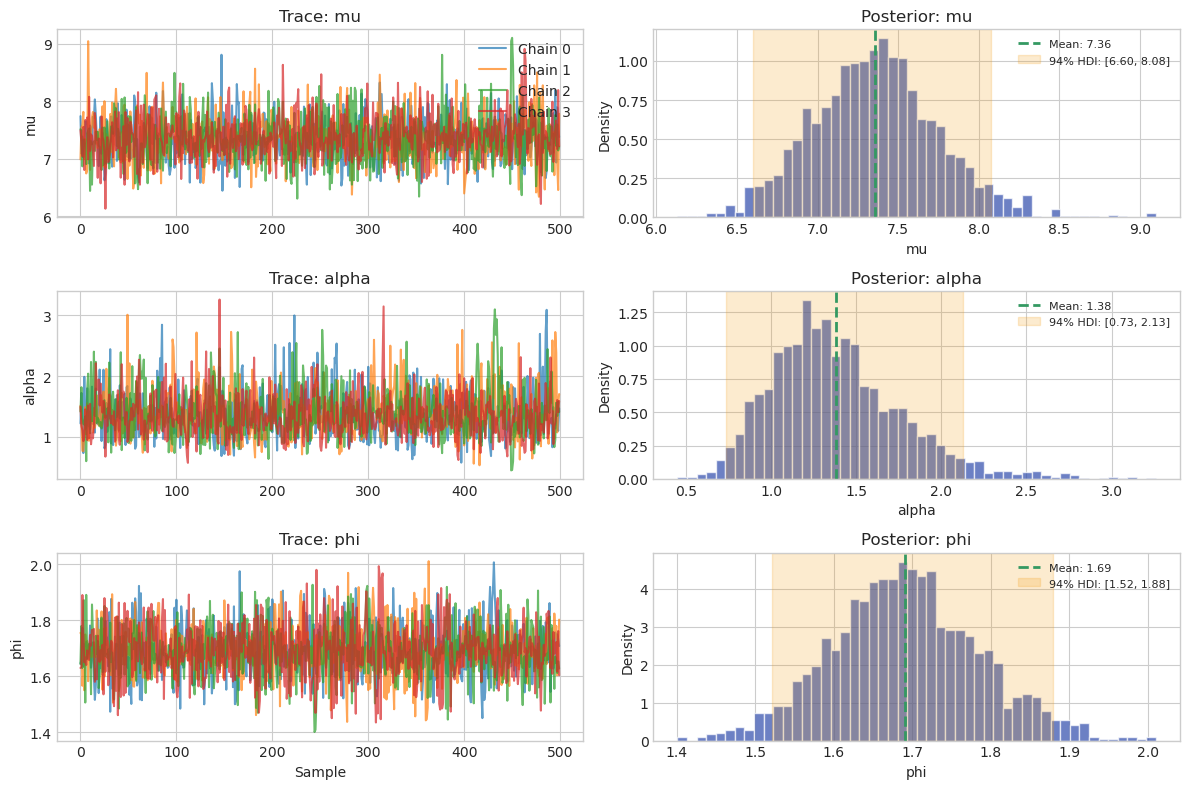

In [16]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

var_names = ['mu', 'alpha', 'phi']
for i, var in enumerate(var_names):
    # Left: Trace (time series of samples)
    ax = axes[i, 0]
    for chain in range(trace.posterior.dims['chain']):
        samples = trace.posterior[var].sel(chain=chain).values
        ax.plot(samples, alpha=0.7, label=f'Chain {chain}')
    ax.set_ylabel(var)
    ax.set_xlabel('Sample' if i == 2 else '')
    ax.set_title(f'Trace: {var}')
    if i == 0:
        ax.legend(loc='upper right')
    
    # Right: Posterior distribution
    ax = axes[i, 1]
    samples = trace.posterior[var].values.flatten()
    ax.hist(samples, bins=50, density=True, color=COLORS['benign'], 
            edgecolor='white', alpha=0.7)
    ax.axvline(np.mean(samples), color=COLORS['attack'], linestyle='--', 
               linewidth=2, label=f'Mean: {np.mean(samples):.2f}')
    
    # 94% HDI
    hdi = az.hdi(trace, var_names=[var], hdi_prob=0.94)[var].values
    ax.axvspan(hdi[0], hdi[1], alpha=0.2, color=COLORS['highlight'],
               label=f'94% HDI: [{hdi[0]:.2f}, {hdi[1]:.2f}]')
    ax.set_xlabel(var)
    ax.set_ylabel('Density')
    ax.set_title(f'Posterior: {var}')
    ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

**Interpretation**

**Trace plots (left column)**: Good mixing looks like "hairy caterpillars":
- Chains should overlap and move randomly around a stable mean
- Bad: Chains stuck in different regions, or slow drift

**Posterior plots (right column)**:
- **μ**: Population mean event rate (around 6-7 events/window)
- **α**: Concentration parameter (controls pooling strength)
- **φ**: Overdispersion parameter

The 94% Highest Density Interval (HDI) shows where 94% of the posterior mass lies.

### 5.4 Question: Does partial pooling work?

**Why this matters**: We want entity rates to shrink toward the population mean, especially for sparse entities.

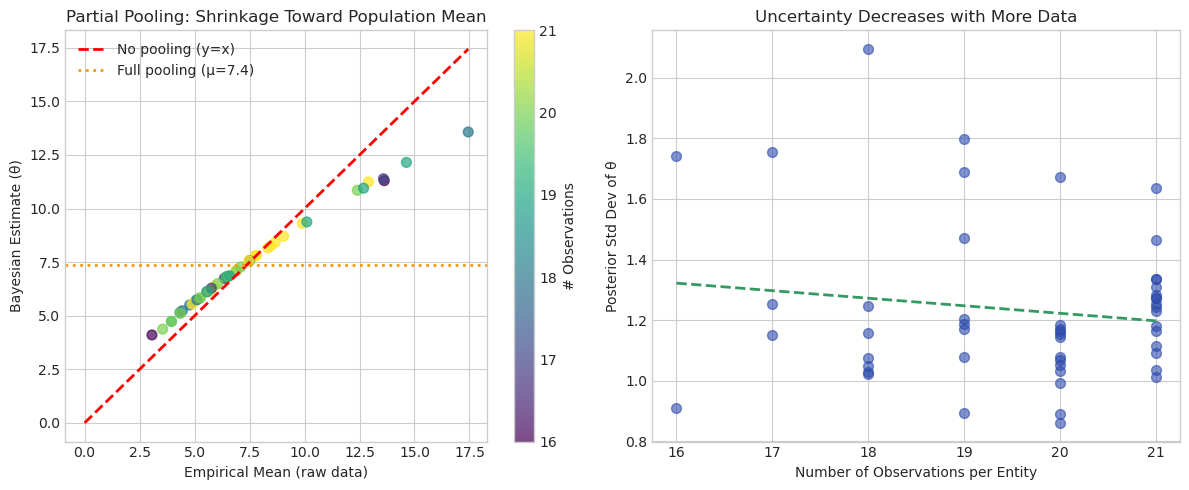

In [17]:
# Get learned theta values
theta_samples = trace.posterior['theta'].values
theta_mean = theta_samples.mean(axis=(0, 1))  # Mean across chains and draws
theta_std = theta_samples.std(axis=(0, 1))

# Get empirical means
empirical = modeling_df.groupby('entity_idx')['event_count'].agg(['mean', 'count']).reset_index()
empirical = empirical.sort_values('entity_idx')

# Population mean from model
mu_mean = trace.posterior['mu'].values.mean()

fig, axes = plt.subplots(1, 2, figsize=FIGSIZE_DOUBLE)

# Left: Shrinkage plot
ax = axes[0]
ax.scatter(empirical['mean'], theta_mean, c=empirical['count'], 
           cmap='viridis', alpha=0.7, s=50)
ax.plot([0, empirical['mean'].max()], [0, empirical['mean'].max()], 
        'r--', label='No pooling (y=x)', linewidth=2)
ax.axhline(mu_mean, color=COLORS['highlight'], linestyle=':', 
           label=f'Full pooling (μ={mu_mean:.1f})', linewidth=2)
ax.set_xlabel('Empirical Mean (raw data)')
ax.set_ylabel('Bayesian Estimate (θ)')
ax.set_title('Partial Pooling: Shrinkage Toward Population Mean')
ax.legend(loc='upper left')
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label('# Observations')

# Right: Uncertainty by observation count
ax = axes[1]
ax.scatter(empirical['count'], theta_std, color=COLORS['benign'], alpha=0.6, s=50)
ax.set_xlabel('Number of Observations per Entity')
ax.set_ylabel('Posterior Std Dev of θ')
ax.set_title('Uncertainty Decreases with More Data')

# Add trend line
z = np.polyfit(empirical['count'], theta_std, 1)
p = np.poly1d(z)
x_line = np.linspace(empirical['count'].min(), empirical['count'].max(), 100)
ax.plot(x_line, p(x_line), color=COLORS['attack'], linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

**Interpretation**

**Left plot (Shrinkage)**:
- Points close to the red dashed line = minimal shrinkage (entity has lots of data)
- Points pulled toward the orange line = strong shrinkage (sparse entity)
- Color gradient shows that entities with **fewer observations** (darker) shrink more

**Right plot (Uncertainty)**:
- More observations → lower posterior standard deviation
- This is the fundamental Bayesian insight: uncertainty decreases with evidence

**Why this matters for anomaly detection**:
- Sparse entities get regularized baselines (less prone to false positives from noise)
- Active entities get precise personalized baselines

In [18]:
io.save_model(trace, settings.model_path)
print(f"Model saved to {settings.model_path}")

Model saved to outputs/model.nc


---
## 6. 🎯 Anomaly Scoring & Uncertainty Quantification
---

### 6.1 The Scoring Formula

$$\text{anomaly\_score}(y) = -\log P(y | \text{posterior})$$

**Intuition**:
- Likely observations → high probability → low score
- Unlikely observations → low probability → high score
- Score incorporates **entity-specific baseline** and **model uncertainty**

In [19]:
scores = steps.compute_scores(y=arrays['y'], trace=trace, entity_idx=arrays['entity_idx'])
intervals = steps.compute_intervals(trace, arrays['entity_idx'])
scored_df = steps.create_scored_df(modeling_df, scores, intervals)

print(f"Scored {len(scored_df)} observations")
print(f"Score range: [{scored_df['anomaly_score'].min():.2f}, {scored_df['anomaly_score'].max():.2f}]")

Scored 978 observations
Score range: [1.88, 21.76]


### 6.2 Question: How well do scores separate attacks from benign?

**Why this matters**: If distributions don't separate, the model cannot discriminate.

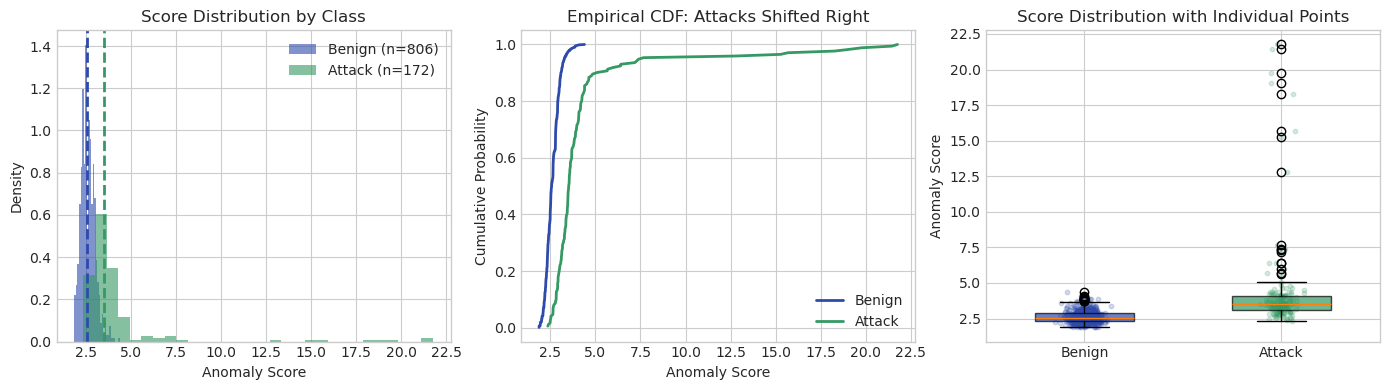

In [20]:
benign_scores = scored_df[~scored_df['has_attack']]['anomaly_score']
attack_scores = scored_df[scored_df['has_attack']]['anomaly_score']

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 1. Overlapping histograms
ax = axes[0]
ax.hist(benign_scores, bins=30, alpha=0.6, density=True, 
        label=f'Benign (n={len(benign_scores)})', color=COLORS['benign'])
ax.hist(attack_scores, bins=30, alpha=0.6, density=True,
        label=f'Attack (n={len(attack_scores)})', color=COLORS['attack'])
ax.axvline(benign_scores.median(), color=COLORS['benign'], linestyle='--', linewidth=2)
ax.axvline(attack_scores.median(), color=COLORS['attack'], linestyle='--', linewidth=2)
ax.set_xlabel('Anomaly Score')
ax.set_ylabel('Density')
ax.set_title('Score Distribution by Class')
ax.legend()

# 2. Empirical CDF
ax = axes[1]
for data, label, color in [(benign_scores, 'Benign', COLORS['benign']), 
                            (attack_scores, 'Attack', COLORS['attack'])]:
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    ax.plot(sorted_data, cdf, label=label, color=color, linewidth=2)
ax.set_xlabel('Anomaly Score')
ax.set_ylabel('Cumulative Probability')
ax.set_title('Empirical CDF: Attacks Shifted Right')
ax.legend()

# 3. Box plot with individual points
ax = axes[2]
positions = [0, 1]
bp = ax.boxplot([benign_scores, attack_scores], positions=positions, 
                widths=0.5, patch_artist=True)
bp['boxes'][0].set_facecolor(COLORS['benign'])
bp['boxes'][1].set_facecolor(COLORS['attack'])
for box in bp['boxes']:
    box.set_alpha(0.7)

# Add scatter for outliers
ax.scatter(np.zeros(len(benign_scores)) + np.random.normal(0, 0.04, len(benign_scores)),
           benign_scores, alpha=0.2, color=COLORS['benign'], s=10)
ax.scatter(np.ones(len(attack_scores)) + np.random.normal(0, 0.04, len(attack_scores)),
           attack_scores, alpha=0.2, color=COLORS['attack'], s=10)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Benign', 'Attack'])
ax.set_ylabel('Anomaly Score')
ax.set_title('Score Distribution with Individual Points')

plt.tight_layout()
plt.show()

**Interpretation**

1. **Histogram**: Attack scores are shifted right (higher), but overlap exists
2. **CDF**: At any score threshold, the attack CDF is always below benign CDF → attacks are stochastically larger
3. **Box plot**: Clear median difference; attack distribution has longer right tail

**Key insight**: Perfect separation is impossible, but attacks concentrate at higher scores. This is why we use **Recall@K** (not accuracy) as our operational metric.

### 6.3 Question: What do the top anomalies look like?

**Why this matters**: We need to verify that high-scoring observations are actually suspicious.

In [21]:
top_n = 15
top_anomalies = scored_df.head(top_n)[
    ['user_id', 'window', 'event_count', 'predicted_mean', 
     'anomaly_score', 'has_attack', 'attack_type']
].copy()

# Add exceedance factor
top_anomalies['exceedance'] = (top_anomalies['event_count'] / 
                                top_anomalies['predicted_mean']).round(1)

print(f"Top {top_n} Anomalies:")
print("="*100)
top_anomalies

Top 15 Anomalies:


,user_id,window,event_count,predicted_mean,anomaly_score,has_attack,attack_type,exceedance
418,user_0021,2024-01-09,198,12.0770,21.759419,True,brute_force,16.4
825,user_0042,2024-01-04,179,11.0415,21.452763,True,credential_stuffing,16.2
248,user_0012,2024-01-18,197,13.7785,19.779479,True,brute_force,14.3
31,user_0001,2024-01-16,158,11.3230,19.057505,True,brute_force,14.0
746,user_0038,2024-01-03,153,11.7805,18.263857,True,brute_force,13.0
506,user_0026,2024-01-01,121,10.9995,15.687698,True,brute_force,11.0
650,user_0033,2024-01-05,104,9.1320,15.281675,True,brute_force,11.4
193,user_0010,2024-01-04,83,9.2910,12.782796,True,credential_stuffing,8.9
38,user_0002,2024-01-03,38,7.3420,7.669706,True,device_anomaly,5.2
297,user_0015,2024-01-06,31,5.9950,7.382411,True,device_anomaly,5.2


**Interpretation**

The table shows:
- **Exceedance**: How many times the observed count exceeds the predicted mean (e.g., 10x = very anomalous)
- **Top ranks are dominated by brute_force** attacks (high-volume, easy to detect)
- Ground truth column confirms these are real attacks

**Note**: The precision at top-N is high, meaning if analysts investigate these, most will be true positives.

### 6.4 Question: How does uncertainty affect our predictions?

**Why this matters**: Predictions without uncertainty are incomplete. Credible intervals tell us how confident we are.

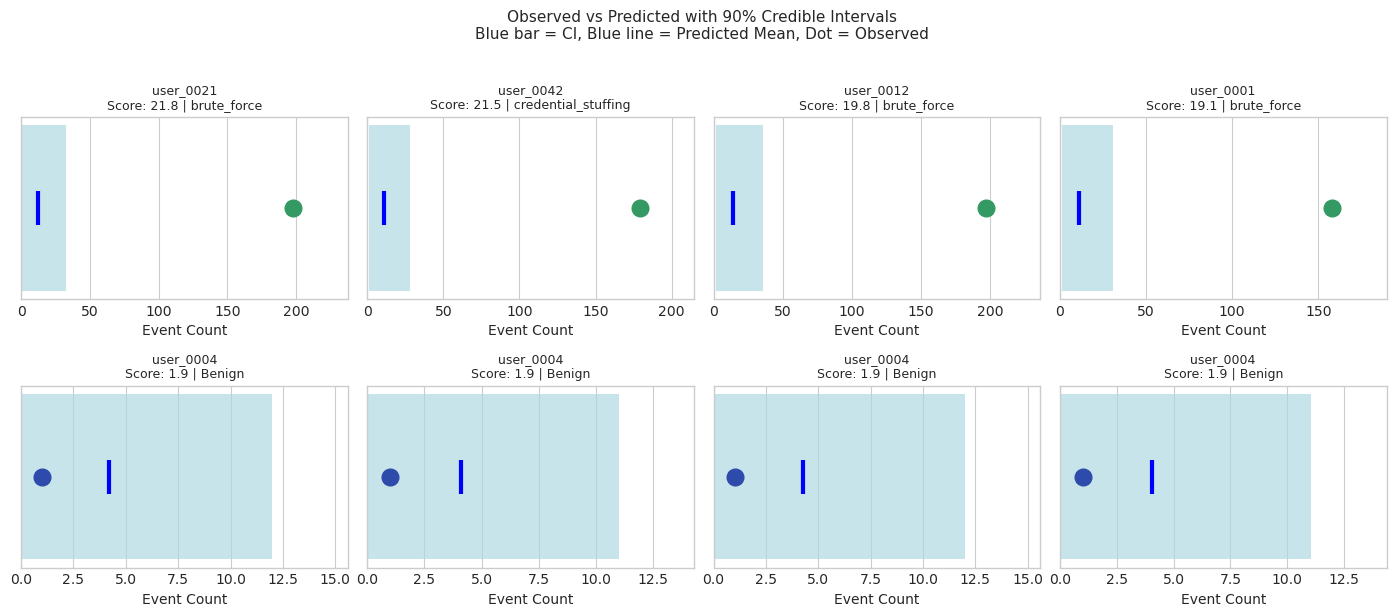

In [22]:
# Select diverse examples: top anomalies + some normal observations
examples_idx = list(scored_df.head(4).index) + list(scored_df.tail(4).index)
examples = scored_df.loc[examples_idx].copy()

fig, axes = plt.subplots(2, 4, figsize=(14, 6))
axes = axes.flatten()

for idx, (i, row) in enumerate(examples.iterrows()):
    ax = axes[idx]
    
    # Credible interval as horizontal band
    ci_width = row['predicted_upper'] - row['predicted_lower']
    ax.barh(0, ci_width, left=row['predicted_lower'], height=0.4,
            color=COLORS['ci_band'], alpha=0.7, label='90% CI')
    
    # Predicted mean
    ax.plot(row['predicted_mean'], 0, 'b|', markersize=25, markeredgewidth=3,
            label=f"Pred: {row['predicted_mean']:.0f}")
    
    # Observed value
    color = COLORS['attack'] if row['has_attack'] else COLORS['benign']
    ax.plot(row['event_count'], 0, 'o', color=color, markersize=12,
            label=f"Obs: {row['event_count']}")
    
    # Formatting
    status = row['attack_type'] if row['has_attack'] else 'Benign'
    ax.set_title(f"{row['user_id']}\nScore: {row['anomaly_score']:.1f} | {status}", fontsize=9)
    ax.set_xlim([0, max(row['predicted_upper'] * 1.3, row['event_count'] * 1.2)])
    ax.set_yticks([])
    ax.set_xlabel('Event Count')
    
plt.suptitle('Observed vs Predicted with 90% Credible Intervals\n'
             'Blue bar = CI, Blue line = Predicted Mean, Dot = Observed', 
             y=1.02, fontsize=11)
plt.tight_layout()
plt.show()

**Interpretation**

**Top row (high scores = anomalies)**:
- Observed values (dots) are **far outside** the credible interval
- Large exceedance = high anomaly score

**Bottom row (low scores = normal)**:
- Observed values fall **within** or near the credible interval
- No surprise = low anomaly score

**Key insight**: The model's uncertainty matters. A count of 30 might be:
- Normal if CI is [5, 50]
- Anomalous if CI is [2, 10]

### 6.5 Visualization: Posterior Predictive Check

**Question**: Does the model generate data that looks like the real data?

In [23]:
# Generate posterior predictive samples
from scipy.stats import nbinom

# Get theta samples - use shape directly from array instead of dimension name
theta_raw = trace.posterior['theta'].values  # shape: (chains, draws, n_entities)
n_chains, n_draws, n_entities = theta_raw.shape
theta_samples = theta_raw.reshape(-1, n_entities)  # shape: (chains*draws, n_entities)
phi_samples = trace.posterior['phi'].values.flatten()

# Sample from posterior predictive for a subset of observations
n_pp_samples = 500
pp_samples = []

for _ in range(n_pp_samples):
    idx = np.random.randint(len(phi_samples))
    phi = phi_samples[idx]
    theta = theta_samples[idx]
    
    # Generate one sample per entity-observation
    entity_idx = arrays['entity_idx']
    theta_obs = theta[entity_idx]
    p = phi / (phi + theta_obs)
    y_rep = nbinom.rvs(n=phi, p=p)
    pp_samples.append(y_rep)

pp_samples = np.array(pp_samples)
print(f"Generated {n_pp_samples} posterior predictive samples")

Generated 500 posterior predictive samples


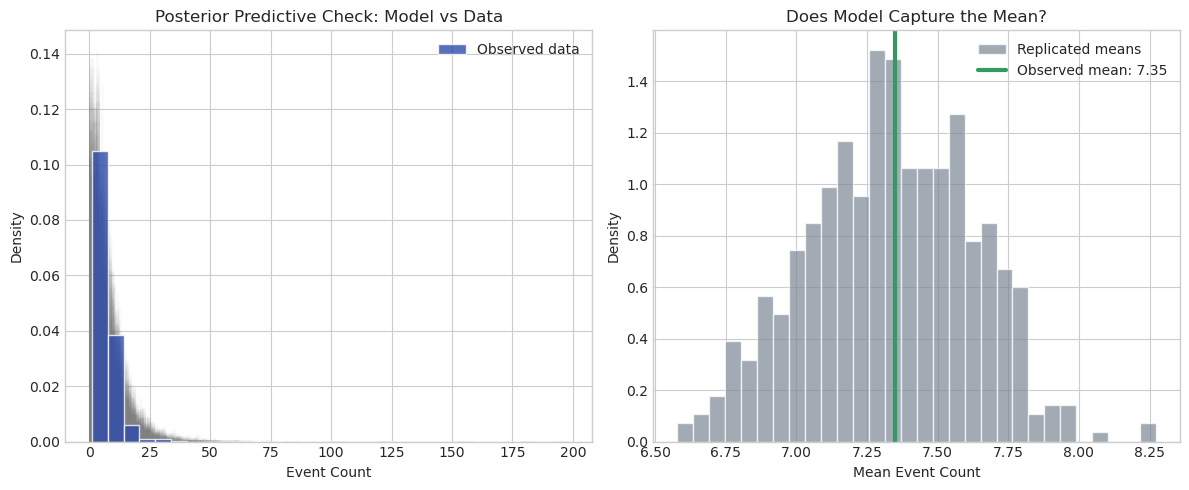

In [24]:
fig, axes = plt.subplots(1, 2, figsize=FIGSIZE_DOUBLE)

# Left: Density comparison
ax = axes[0]
# Plot posterior predictive samples (gray)
for i in range(min(100, n_pp_samples)):
    ax.hist(pp_samples[i], bins=30, density=True, alpha=0.03, color='gray')

# Plot observed data (blue)
ax.hist(arrays['y'], bins=30, density=True, alpha=0.8, color=COLORS['benign'],
        edgecolor='white', label='Observed data')
ax.set_xlabel('Event Count')
ax.set_ylabel('Density')
ax.set_title('Posterior Predictive Check: Model vs Data')
ax.legend()

# Right: Mean comparison
ax = axes[1]
pp_means = pp_samples.mean(axis=1)
observed_mean = arrays['y'].mean()

ax.hist(pp_means, bins=30, density=True, color=COLORS['neutral'], 
        edgecolor='white', alpha=0.7, label='Replicated means')
ax.axvline(observed_mean, color=COLORS['attack'], linewidth=3,
           label=f'Observed mean: {observed_mean:.2f}')
ax.set_xlabel('Mean Event Count')
ax.set_ylabel('Density')
ax.set_title('Does Model Capture the Mean?')
ax.legend()

plt.tight_layout()
plt.show()

**Interpretation**

**Left plot**: Gray histograms are data generated from the posterior predictive. The blue histogram is actual data. Good fit = similar shapes.

**Right plot**: The red line (observed mean) should fall within the distribution of replicated means. If outside, the model is systematically biased.

**This is a "sanity check"**: If the model can't generate data similar to what we observed, something is wrong.

In [25]:
io.save_parquet(scored_df, settings.scores_path)
print(f"Scores saved to {settings.scores_path}")

Scores saved to outputs/scores.parquet


---
## 7. 📊 Evaluation & Decision Analysis
---

In [26]:
metrics = steps.evaluate(scored_df)

### 7.1 Question: How good is our overall discrimination?

**Why PR-AUC, not ROC-AUC?**

In [27]:
print("="*60)
print("EVALUATION METRICS")
print("="*60)
print(f"\n{'Metric':<20} {'Value':<15} {'Interpretation'}")
print("-"*60)
print(f"{'PR-AUC':<20} {metrics['pr_auc']:<15.3f} Area under Precision-Recall curve")
print(f"{'ROC-AUC':<20} {metrics['roc_auc']:<15.3f} Area under ROC curve")
print(f"{'Attack Rate':<20} {metrics['attack_rate']:<15.2%} Baseline for PR-AUC")
print("\nNote: PR-AUC baseline = attack rate. Good model should be >> baseline.")
print(f"      Our model: {metrics['pr_auc']:.3f} vs baseline {metrics['attack_rate']:.3f}")
print(f"      Lift over baseline: {metrics['pr_auc']/metrics['attack_rate']:.1f}x")

EVALUATION METRICS

Metric               Value           Interpretation
------------------------------------------------------------
PR-AUC               0.762           Area under Precision-Recall curve
ROC-AUC              0.910           Area under ROC curve
Attack Rate          17.59%          Baseline for PR-AUC

Note: PR-AUC baseline = attack rate. Good model should be >> baseline.
      Our model: 0.762 vs baseline 0.176
      Lift over baseline: 4.3x


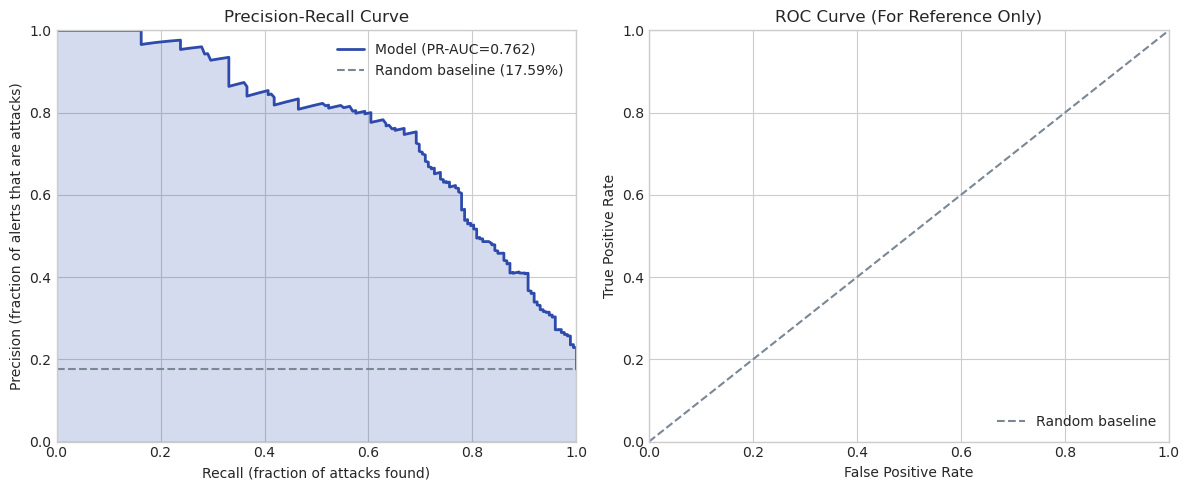

In [28]:
fig, axes = plt.subplots(1, 2, figsize=FIGSIZE_DOUBLE)

# Left: Precision-Recall Curve
ax = axes[0]
if 'pr_curve' in metrics:
    ax.plot(metrics['pr_curve']['recall'], metrics['pr_curve']['precision'],
            color=COLORS['benign'], linewidth=2, label=f"Model (PR-AUC={metrics['pr_auc']:.3f})")
    ax.fill_between(metrics['pr_curve']['recall'], metrics['pr_curve']['precision'],
                    alpha=0.2, color=COLORS['benign'])
ax.axhline(metrics['attack_rate'], color=COLORS['neutral'], linestyle='--',
           label=f"Random baseline ({metrics['attack_rate']:.2%})")
ax.set_xlabel('Recall (fraction of attacks found)')
ax.set_ylabel('Precision (fraction of alerts that are attacks)')
ax.set_title('Precision-Recall Curve')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.legend(loc='upper right')

# Right: ROC Curve (for comparison)
ax = axes[1]
if 'roc_curve' in metrics:
    ax.plot(metrics['roc_curve']['fpr'], metrics['roc_curve']['tpr'],
            color=COLORS['benign'], linewidth=2, label=f"Model (ROC-AUC={metrics['roc_auc']:.3f})")
    ax.fill_between(metrics['roc_curve']['fpr'], metrics['roc_curve']['tpr'],
                    alpha=0.2, color=COLORS['benign'])
ax.plot([0, 1], [0, 1], color=COLORS['neutral'], linestyle='--', label='Random baseline')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve (For Reference Only)')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

**Interpretation**

**Why PR-AUC is better for rare events**:
- ROC-AUC can be high (0.95+) even with poor precision because it's dominated by true negatives
- PR-AUC focuses on the positive class (attacks) which is what we care about
- Random baseline for PR-AUC = attack rate; our model should be significantly higher

**Key insight**: A model with 0.9 ROC-AUC might still have 50% precision at reasonable recall. Always check both curves.

### 7.2 Question: If analysts investigate K alerts per day, how many attacks will they find?

**This is the operational question**: Recall@K directly maps to SOC workflow.

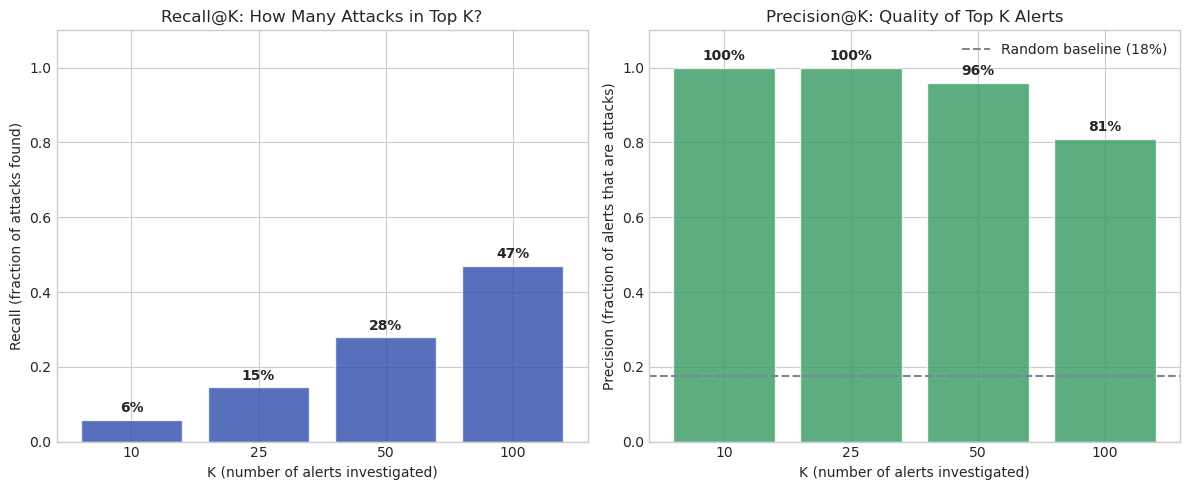

In [29]:
k_values = [10, 25, 50, 100, 150, 200]
recall_data = []
precision_data = []

for k in k_values:
    if f'recall_at_{k}' in metrics:
        recall_data.append(metrics[f'recall_at_{k}'])
        precision_data.append(metrics.get(f'precision_at_{k}', 0))

fig, axes = plt.subplots(1, 2, figsize=FIGSIZE_DOUBLE)

# Left: Recall@K
ax = axes[0]
bars = ax.bar([str(k) for k in k_values[:len(recall_data)]], recall_data, 
              color=COLORS['benign'], edgecolor='white', alpha=0.8)
for bar, val in zip(bars, recall_data):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.0%}', ha='center', fontweight='bold')
ax.set_xlabel('K (number of alerts investigated)')
ax.set_ylabel('Recall (fraction of attacks found)')
ax.set_title('Recall@K: How Many Attacks in Top K?')
ax.set_ylim([0, 1.1])

# Right: Precision@K
ax = axes[1]
bars = ax.bar([str(k) for k in k_values[:len(precision_data)]], precision_data,
              color=COLORS['attack'], edgecolor='white', alpha=0.8)
for bar, val in zip(bars, precision_data):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.0%}', ha='center', fontweight='bold')
ax.axhline(metrics['attack_rate'], color=COLORS['neutral'], linestyle='--',
           label=f"Random baseline ({metrics['attack_rate']:.0%})")
ax.set_xlabel('K (number of alerts investigated)')
ax.set_ylabel('Precision (fraction of alerts that are attacks)')
ax.set_title('Precision@K: Quality of Top K Alerts')
ax.set_ylim([0, 1.1])
ax.legend()

plt.tight_layout()
plt.show()

**Interpretation**

**Recall@K (left)**: "If I investigate K alerts, what fraction of all attacks do I catch?"
- Recall@50 = 40% means investigating 50 alerts catches 40% of attacks
- Diminishing returns as K increases

**Precision@K (right)**: "Of the K alerts I investigate, what fraction are true attacks?"
- Precision@10 = 100% means all top 10 are real attacks (perfect quality)
- Precision decreases as K increases (more false positives enter)

**Operational tradeoff**: High K catches more attacks but wastes analyst time on false positives.

### 7.3 Question: How does precision/recall trade off with threshold choice?

In [30]:
thresholds = np.linspace(scored_df['anomaly_score'].min(), 
                          scored_df['anomaly_score'].quantile(0.9), 20)

threshold_results = []
for t in thresholds:
    flagged = scored_df[scored_df['anomaly_score'] > t]
    n_flagged = len(flagged)
    n_attacks = flagged['has_attack'].sum() if n_flagged > 0 else 0
    
    precision = n_attacks / n_flagged if n_flagged > 0 else 0
    recall = n_attacks / metrics['n_positives'] if metrics['n_positives'] > 0 else 0
    
    threshold_results.append({
        'threshold': t,
        'n_flagged': n_flagged,
        'precision': precision,
        'recall': recall,
    })

tr_df = pd.DataFrame(threshold_results)

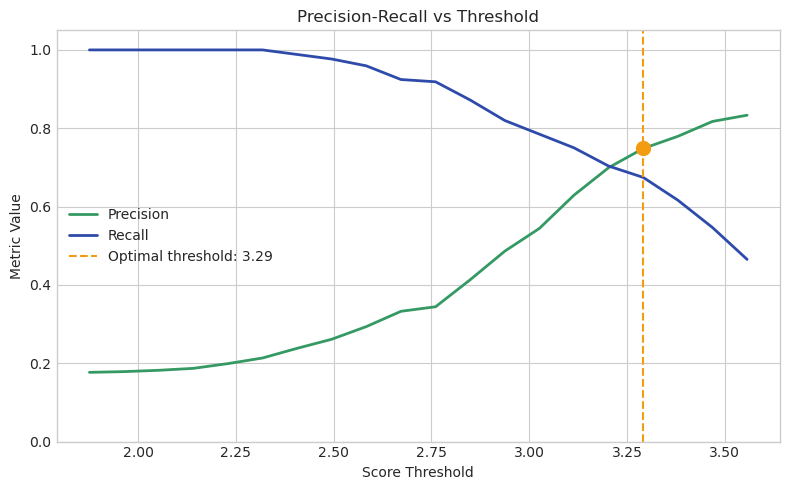

Optimal threshold (max F1): 3.29
  Precision: 74.84%
  Recall: 67.44%
  Alerts flagged: 155.0


In [31]:
fig, ax = plt.subplots(figsize=FIGSIZE_SINGLE)

ax.plot(tr_df['threshold'], tr_df['precision'], label='Precision', 
        color=COLORS['attack'], linewidth=2)
ax.plot(tr_df['threshold'], tr_df['recall'], label='Recall',
        color=COLORS['benign'], linewidth=2)

# Find intersection (F1-optimal point)
f1_scores = 2 * (tr_df['precision'] * tr_df['recall']) / (tr_df['precision'] + tr_df['recall'] + 1e-10)
best_idx = f1_scores.argmax()
best_threshold = tr_df.iloc[best_idx]['threshold']

ax.axvline(best_threshold, color=COLORS['highlight'], linestyle='--', 
           label=f'Optimal threshold: {best_threshold:.2f}')
ax.scatter([best_threshold], [tr_df.iloc[best_idx]['precision']], 
           color=COLORS['highlight'], s=100, zorder=5)

ax.set_xlabel('Score Threshold')
ax.set_ylabel('Metric Value')
ax.set_title('Precision-Recall vs Threshold')
ax.legend()
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

print(f"Optimal threshold (max F1): {best_threshold:.2f}")
print(f"  Precision: {tr_df.iloc[best_idx]['precision']:.2%}")
print(f"  Recall: {tr_df.iloc[best_idx]['recall']:.2%}")
print(f"  Alerts flagged: {tr_df.iloc[best_idx]['n_flagged']}")

**Interpretation**

This plot shows the fundamental tradeoff:
- **High threshold**: High precision (few false positives), low recall (miss many attacks)
- **Low threshold**: High recall (catch most attacks), low precision (many false positives)

**Choosing the threshold**:
- **Cost-sensitive**: If missing an attack is very costly, use low threshold
- **Capacity-limited**: If analyst time is limited, use high threshold
- **F1-optimal**: Balance between precision and recall (orange line)

### 7.4 Visualization: Cumulative Attack Detection

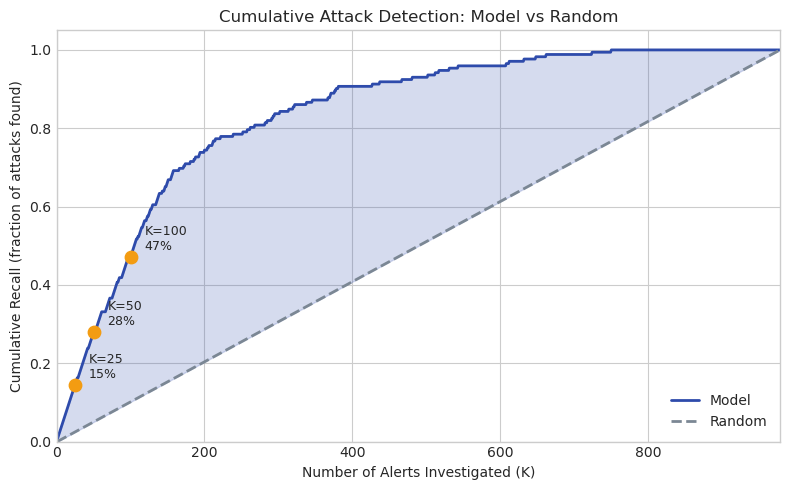

In [32]:
# Sorted by score (already done in scored_df)
cumulative_attacks = scored_df['has_attack'].cumsum()
total_attacks = scored_df['has_attack'].sum()
cumulative_recall = cumulative_attacks / total_attacks

fig, ax = plt.subplots(figsize=FIGSIZE_SINGLE)

# Model curve
ax.plot(range(1, len(cumulative_recall) + 1), cumulative_recall,
        color=COLORS['benign'], linewidth=2, label='Model')

# Random baseline
random_recall = np.linspace(0, 1, len(cumulative_recall))
ax.plot(range(1, len(cumulative_recall) + 1), random_recall,
        color=COLORS['neutral'], linestyle='--', linewidth=2, label='Random')

# Highlight key points
for k in [25, 50, 100]:
    if k <= len(cumulative_recall):
        ax.scatter([k], [cumulative_recall.iloc[k-1]], s=80, 
                   color=COLORS['highlight'], zorder=5)
        ax.annotate(f'K={k}\n{cumulative_recall.iloc[k-1]:.0%}',
                    (k, cumulative_recall.iloc[k-1]),
                    textcoords='offset points', xytext=(10, 5), fontsize=9)

ax.set_xlabel('Number of Alerts Investigated (K)')
ax.set_ylabel('Cumulative Recall (fraction of attacks found)')
ax.set_title('Cumulative Attack Detection: Model vs Random')
ax.legend(loc='lower right')
ax.set_xlim([0, len(cumulative_recall)])
ax.set_ylim([0, 1.05])

# Fill area between curves (lift)
ax.fill_between(range(1, len(cumulative_recall) + 1), 
                cumulative_recall, random_recall,
                where=(cumulative_recall > random_recall),
                alpha=0.2, color=COLORS['benign'], label='Lift over random')

plt.tight_layout()
plt.show()

**Interpretation**

The shaded area represents the **lift** over random selection:
- At K=50, model finds ~40% of attacks vs ~8% for random
- Early ranks have highest value (steepest curve)
- Eventually converges (if you investigate everything, you find everything)

**Operational insight**: The model's value is in prioritization. The first 100 alerts are worth more than the next 500.

In [33]:
io.save_json(metrics, settings.metrics_path)
print(f"Metrics saved to {settings.metrics_path}")

Metrics saved to outputs/metrics.json


---
## 8. ⚠️ Common Misinterpretations
---

This section addresses frequent mistakes when interpreting anomaly detection results.

### Misinterpretation 1: "A high anomaly score means it's an attack"

**Reality**: A high score means the observation is **statistically unusual** given the entity's learned baseline. It could be:
- A real attack
- A legitimate but rare behavior (e.g., batch processing day)
- Data quality issue

**Always investigate high-scoring alerts before labeling them as attacks.**

### Misinterpretation 2: "A low anomaly score means it's safe"

**Reality**: A low score means the observation is **consistent with the model's expectations**. This misses:
- Novel attack types the model wasn't trained on
- Attacks that mimic normal behavior (low-and-slow)
- Behavioral anomalies (our model uses counts only, not geo/device features)

**Anomaly detection is one layer of defense, not a complete solution.**

### Misinterpretation 3: "The model has 90% ROC-AUC so it's great"

**Reality**: ROC-AUC is inflated by true negatives. With 2% attack rate:
- A model that predicts "no attack" always gets ~98% accuracy
- ROC-AUC might be 0.9+ while precision is only 10%

**Use PR-AUC and Recall@K for rare event detection.**

### Misinterpretation 4: "We should use the threshold that maximizes F1"

**Reality**: F1 assumes equal cost of false positives and false negatives. In security:
- Missing an attack (FN) might cost millions
- Investigating a false positive (FP) costs analyst time

**Threshold choice should be driven by business costs, not F1.**

### Misinterpretation 5: "The credible interval tells me where attacks will be"

**Reality**: The 90% CI tells you where **normal observations** are expected to fall. Points outside the CI are surprising, but:
- ~10% of normal observations should naturally fall outside the 90% CI
- Very extreme attacks will be far outside, but subtle attacks may be just outside

**CI exceedance is a necessary but not sufficient condition for attack detection.**

---
## 9. 🧪 Exercises for Deeper Understanding
---

### Exercise A: What happens with stronger pooling?

**Hypothesis**: Stronger pooling (smaller α prior) should:
- Make entity rates more similar to each other
- Reduce variance in θ estimates
- Potentially increase false positives for naturally high-activity entities

In [34]:
# Uncomment to test stronger pooling:
# settings_strong = Settings(
#     n_entities=50,
#     n_days=14,
#     n_samples=300,
#     n_tune=300,
#     n_chains=2,
#     alpha_prior_sd=0.5,  # Smaller = stronger pooling
# )
# trace_strong = steps.train_model(arrays, settings_strong)
# theta_strong = trace_strong.posterior['theta'].values.mean(axis=(0,1))
# print(f"Original θ std: {theta_mean.std():.2f}")
# print(f"Strong pooling θ std: {theta_strong.std():.2f}")

### Exercise B: What if we used hourly instead of daily windows?

**Hypothesis**: Smaller windows should:
- Better detect short-duration attacks
- Have more zero-count windows
- Potentially be harder to model (more sparsity)

In [35]:
# Uncomment to test hourly windows:
# settings_hourly = Settings(
#     n_entities=50,
#     n_days=7,  # Less days to keep manageable
#     window_size="1H",  # Hourly instead of daily
#     n_samples=300,
#     n_tune=300,
# )
# events_h, _ = steps.generate_data(settings_hourly)
# modeling_h, _ = steps.build_features(events_h, settings_hourly)
# print(f"Daily windows: {len(modeling_df)}")
# print(f"Hourly windows: {len(modeling_h)}")
# print(f"Zero-count windows (hourly): {(modeling_h['event_count']==0).sum()}")

### Exercise C: What's the effect of attack type on detectability?

**Hypothesis**: High-volume attacks (brute_force) should be more detectable than subtle attacks (geo_anomaly).

In [36]:
attack_detection = scored_df[scored_df['has_attack']].copy()

# Calculate detection rate at different K thresholds
for k in [25, 50, 100]:
    top_k_attacks = scored_df.head(k)['attack_type'].value_counts()
    total_by_type = attack_detection['attack_type'].value_counts()
    
    print(f"\n=== Detection in Top {k} ===")
    for attack_type in total_by_type.index:
        if attack_type != 'none':
            detected = top_k_attacks.get(attack_type, 0)
            total = total_by_type[attack_type]
            print(f"  {attack_type:<20}: {detected}/{total} = {detected/total:.0%}")


=== Detection in Top 25 ===
  credential_stuffing : 11/154 = 7%
  device_anomaly      : 8/9 = 89%
  brute_force         : 6/6 = 100%
  geo_anomaly         : 0/3 = 0%

=== Detection in Top 50 ===
  credential_stuffing : 32/154 = 21%
  device_anomaly      : 8/9 = 89%
  brute_force         : 6/6 = 100%
  geo_anomaly         : 2/3 = 67%

=== Detection in Top 100 ===
  credential_stuffing : 65/154 = 42%
  device_anomaly      : 8/9 = 89%
  brute_force         : 6/6 = 100%
  geo_anomaly         : 2/3 = 67%


**Interpretation**: As expected, brute_force attacks (high volume) are detected more reliably than geo_anomaly or device_anomaly (behavioral changes that don't necessarily increase event counts).

**Implication**: This model excels at volume-based anomalies. Detecting behavioral anomalies would require additional features.

---
## 10. Summary & Key Takeaways
---

### What We Learned

| Topic | Key Insight |
|-------|-------------|
| **Distribution** | Event counts are overdispersed → Negative Binomial, not Poisson |
| **Entity variation** | 5x variation in baselines → Hierarchical model with partial pooling |
| **Partial pooling** | Sparse entities borrow strength from population; active entities get personalized baselines |
| **Uncertainty** | Credible intervals quantify prediction confidence |
| **Scoring** | -log(probability) naturally ranks observations by surprise |
| **Evaluation** | PR-AUC and Recall@K for rare events; ROC-AUC is misleading |

### Limitations

1. **Count-based only**: Misses behavioral anomalies without volume changes
2. **No temporal dynamics**: Each window is independent (no drift detection)
3. **Synthetic data**: Real logs have different characteristics
4. **MCMC scalability**: Slow for millions of entities (use variational inference)

### Next Steps

- **Production**: Replace synthetic data with real security logs
- **Features**: Add behavioral features (unique IPs, locations, devices)
- **Scale**: Use variational inference for large entity counts
- **Temporal**: Add time-series components (HMM, changepoint detection)

---

*This notebook demonstrates principled Bayesian anomaly detection with explicit uncertainty quantification. Every visualization answers a question. Every result has an interpretation.*